This example code will download a 5 minute high frequency hydrophone clip in mseed file format from ocean observatories raw data repository or load a previously downloaded clip and then use obsspy to plot it and save it as a wave file 

To run this in Anaconda you may need to load an extra library if not already loaded. The first is obspy (obs for ocean bottom seismometers) as this knows how to load mseed files - a standard in seismic community - and how the high frequency hydrophone data is stored in on the raw data repository. See the note here on how to install the binaries here: https://github.com/obspy/obspy/wiki/Installation-via-Anaconda

This notebook is based on the workbook from Pete Cable - https://github.com/petercable/shared_notebooks/blob/master/antelope/Antelope_to_WAV.ipynb

In [75]:
from obspy import read
from obspy.core import UTCDateTime
import wave
import datetime
import matplotlib
from ipywidgets import widgets
import matplotlib.pyplot as plt
import soundfile as sf
import sounddevice as sd

%matplotlib inline
data_url = 'https://rawdata.oceanobservatories.org/files/RS01SLBS/LJ01A/09-HYDBBA102/2017/10/06/OO-HYVM1--YDH-2017-10-06T20:10:00.000015.mseed'
localFileName = '../data/merged_hydrophone.mseed'

You can download directly from OOI in the program via the url or to speed up development download the file and place it in the same directory as this notebook and then read the local file.

In [76]:
loadFromOOI=False

if loadFromOOI==True :
    stream = read(data_url)
else:
    stream = read(localFileName)  # Read Previoulsy Download local file for speed

# print some stats about this signal
stream

1 Trace(s) in Stream:
OO.HYVM2..YDH | 2017-08-21T09:00:00.000000Z - 2017-08-21T11:00:04.450547Z | 64000.0 Hz, 461084836 samples

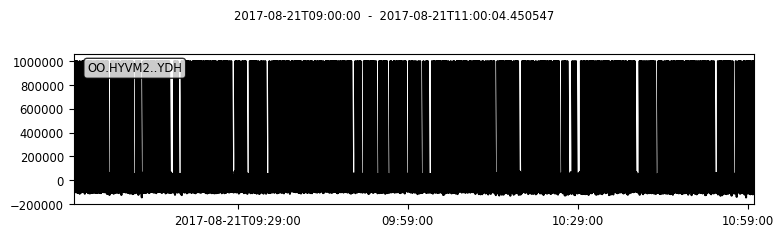

In [38]:
#Documentation about the obspy library is here https://docs.obspy.org/contents.html
# and list of things you can do with a stream now that its loaded is here
#https://docs.obspy.org/packages/autogen/obspy.core.stream.Stream.html

#plot the entire 5 minute clip
stream.plot()

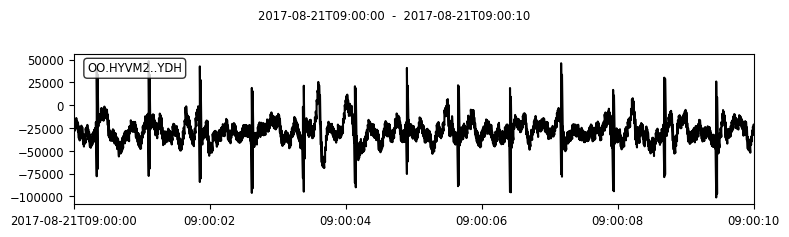

In [77]:
#zoom in and look at just 5 seconds - The spikes every 1/sec are from a co-located ADCP

dt = UTCDateTime("2017-08-21T09:00:00")
st = stream.slice(dt, dt + 10)
st.plot()


In [78]:


def spec(Num):
    dt = UTCDateTime("2017-08-21T09:00:00")
    print(dt)
    st = stream.slice(dt + Num, dt + Num + 10)
    
    #x=np.array([row[Number] for row in stream])
    fig, ax = plt.subplots()
    pxx, freq, t, cax = ax.specgram(st[0],Fs=64000,noverlap=5, cmap='plasma')
    # c axis
    cbar = fig.colorbar(cax)
    cbar.set_label('Intensity dB')
    ax.axis("tight")
    # y axis   
    ax.set_ylabel('Frequency [kHz]')
    scale = 1e3                     # KHz
    ticks = matplotlib.ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale))
    ax.yaxis.set_major_formatter(ticks)
    # x axis 
    ax.set_xlabel('Time h:mm:ss')
    def timeTicks(x, pos):
        d = UTCDateTime("2017-08-21T09:00:00").second+Num*30+x
        #d = datetime.timedelta(seconds=x)
        return str(d)
    formatter = matplotlib.ticker.FuncFormatter(timeTicks)
    ax.xaxis.set_major_formatter(formatter)
    
    plt.show()
widgets.interact(spec, Num=widgets.IntSlider(min=0,max=10,value=0,step =1,continuous_update=False))


interactive(children=(IntSlider(value=0, continuous_update=False, description='Num', max=10), Output()), _dom_classes=('widget-interact',))

<function __main__.spec>

In [79]:
st[0].stats

         network: OO
         station: HYVM2
        location: 
         channel: YDH
       starttime: 2017-08-21T09:00:00.000000Z
         endtime: 2017-08-21T09:00:10.000000Z
   sampling_rate: 64000.0
           delta: 1.5625e-05
            npts: 640001
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 237553, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 4096, 'filesize': 973017088})
      processing: ['ObsPy 1.1.0: trim(endtime=UTCDateTime(2017, 8, 21, 9, 0, 10)::fill_value=None::nearest_sample=True::pad=False::starttime=UTCDateTime(2017, 8, 21, 9, 0))']

In [80]:
def getSamplingFreq(s):
    string = str(s).split(" ")
    fs = 0;
    for i in range(0, len(string) - 1) :
        char = string[i] 
        count = 1
        if (char == "|"):
            count = count + 1
        if (count == 2):
            fs = string[i + 1]
    return float(fs)

def plotFFT(s):
    y = s[0].copy()
    length = len(s[0])
    N = 512
    Fs = getSamplingFreq(s)
    Y = fftshift(fft(y, N))
    f = fftshift(fftfreq(N, 1/Fs))
    Y = np.abs(np.transpose(Y))
    fig = plt.figure(figsize=(10, 10), dpi=100)
    plt.subplot(2,1,1)
    plt.xlim(0,Fs/2)
    #plt.semilogy(f,Y)
    plt.stem(f,Y)
    plt.title("Fourier Transform (N = " + str(N) + "): Frequency Content of " + str((length-1)/Fs) +  " s")
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Magnitude")
    plt.subplot(2,1,2)
    f, t, Sxx = signal.spectrogram(np.transpose(y), Fs)
    plt.pcolormesh(t, f, Sxx, cmap='plasma')
    plt.title("Spectrogram:" + str((length-1)/Fs) +  " s")
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()

st_filt = st.filter('highpass', freq=2.0)
plotFFT(st_filt)
stream_filt = stream.filter('highpass', freq=2.0)
plotFFT(stream_filt)

NameError: name 'fftshift' is not defined

In [ ]:
#write it to an audio file that can it can be played in like Audacity
#lets convert it to something easy to play on a PC
trace = stream[0].copy()
#trace.filter('highpass', freq=2.0)

#convert to full scale and then make 32 bit
trace.normalize()
trace.data = (trace.data * (2**31-1)).astype('int32')

def getSamplingFreq(s):
    string = str(s).split(" ")
    fs = 0;
    for i in range(0, len(string) - 1) :
        char = string[i] 
        count = 1
        if (char == "|"):
            count = count + 1
        if (count == 2):
            fs = string[i + 1]
    return float(fs)

Fs = getSamplingFreq(trace)
samplerate = 4*Fs;
#trace.write('test.wav', format='WAV', framerate=samplerate)

# samples, samplerate = sf.read('test.wav')
# sd.play(samples, samplerate)
# samples, samplerate = sf.read('test.wav')
# Audio(data=samples, rate=samplerate)

sd.play(trace, samplerate)
Audio(data=stream, rate=samplerate)

/Users/sabadi/anaconda/envs/ooi/lib/python3.6/site-packages/obspy/core/trace.py:2176: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(self.data.dtype, float):


/Users/sabadi/anaconda/envs/ooi/lib/python3.6/site-packages/obspy/core/trace.py:2176: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(self.data.dtype, float):


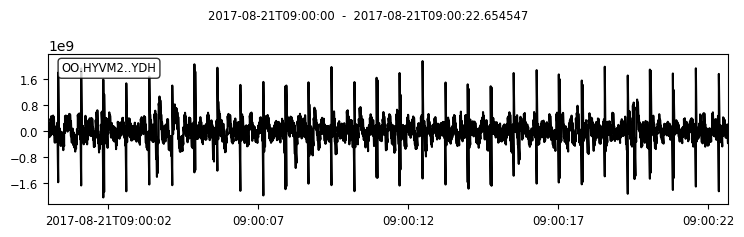

In [15]:
#lets convert it to something easy to play on a PC

trace = stream[0].copy()
trace.filter('highpass', freq=2.0)

#convert to full scale and then make 32 bit

trace.normalize()
trace.data = (trace.data * (2**31-1)).astype('int32')
trace.plot()



In [ ]:
#write it to an audio file that can it can be played in like Audacity

trace.write('test.wav', format='WAV', framerate=64000)